# Spatial Heterogeneity

## Geographically Weighted Regression

### Luc Anselin

### 01/29/2025

## Preliminaries

In this notebook, the first of three that deal with spatial heterogeneity, we consider continuous heterogeneity.
Specifically, we illustrate the Geographically Weighted Regression (GWR) and the more recent Multiscale Geographically Weighted Regression (MGWR), as implemented in the `mgwr` functionality of PySAL. It is assumed that this package is installed as part of PySAL. If this is not the case, use `pip install mgwr`.

Details can be found at https://mgwr.readthedocs.io/en/latest/api.html, as well as in Oshan, Li, Kang, Wolf and Fotheringham (2019), MGWR: A Python implementation of multiscale geographically weighted regression for investigating process spatial heterogeneity and scale. *International Journal of Geo-Information* 8, 269.

### Modules Needed

We import all the usual modules as before. In addition, we will use `stddev_breaks` and `hinge15_breaks` from `pygeoda` for the various maps, `OLS` from `spreg`, `GWR` and `MGWR` from `mgwr.gwr`, `Sel_BW` from `mgwr.sel_bw`, and `StandardScaler` from `sklearn.preprocessing`. To make sure you have the latest version of `pygeoda`, use `pip install -U pygeoda`.

In [2]:
import numpy as np
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
from pygeoda import stddev_breaks, hinge15_breaks
from libpysal.examples import get_path
from spreg import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
np.set_printoptions(legacy="1.25")

### Functions Used

- from libpysal.examples
  - get_path

- from geopandas:
  - read_file
  - plot
  
- from pandas:
  - DataFrame
  - describe
  - merge
  
- from spreg:
  - OLS

- from mgwr:
  - Sel_BW
  - GWR
  - MGWR

- from pygeoda:
  - stddev_breaks
  - hinge15_breaks

- from sklearn.preprocessing:
  - StandardScaler

- custom function:
  - gwr_map

### Files

We will continue to use the data on socio-economic correlates of health outcomes contained in the **Chi_SDOH** sample data set. This is the only data input we need. There are no spatial weights in GWR.

### Read in Data

We use the same process as before, reading the shape file from the sample data using `geopandas`. The variable names are specified to extract `y` and `X` as numpy arrays from the data frame that is read in. We use the same specification as before, with `YPLL_rate` as the dependent variable and `Blk14P`, `Hisp14P` and `HIS_ct` as the explanatory variables. As in `spreg`, the constant term is handled internally by the GWR routines and does not need to be specified.

In [3]:
infileshp = get_path("Chi-SDOH.shp")        
y_name = 'YPLL_rate'
x_names = ['Blk14P','Hisp14P','HIS_ct']
ds_name = 'Chi-SDOH'

In [4]:
dfs = gpd.read_file(infileshp)

### Coordinates and Model Specification

We extract the coordinates `COORD_X` and `COORD_Y` from the data frame and turn them into the list
format required by `mgwr`. We now also create the numpy arrays for `y` and `x`.

In [5]:
coords = list(zip(dfs['COORD_X'],dfs['COORD_Y']))
y = np.array(dfs[y_name]).reshape(-1,1)
x = np.array(dfs[x_names])

As a point of reference, we run a standard OLS regression without any diagnostics.

In [6]:
reg1 = OLS(y,x,name_ds=ds_name,
           name_y = y_name,name_x = x_names,
           nonspat_diag=False)
print(reg1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :        None
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :           4
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         787
R-squared           :      0.6330
Adjusted R-squared  :      0.6316

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       938.33431       217.72938         4.30964         0.00002
              Blk14P        42.09396         3.49108        12.05757         0.00000
             Hisp14P       -14.55534         4.43781        

## GWR

The GWR estimation process operates in two stages. First, a bandwidth must be selected for a given kernel function. This can be either adaptive (a number of nearest neighbors) or fixed (a distance) and can be set manually or determined by means of an optimal `search`. The search can be based on several measures of fit, such as `AIC`, adjusted AIC (`AICc`), `BIC`, or a cross-validation approach (`CV`). See the API description and the article cited in the introduction for specifics on the implementation of these measures in GWR.

With a bandwidth and kernel function specified, the `GWR` method then fits an individual set of coefficients for each observation. The result object contains many pieces of information, too many to be all considered here (see the docs). We focus on arguably the most important aspects, including the location-specific coefficients, the associated significance and their spatial distribution, various global and local diagnostics and an assessment and visualization of local fit.

### Bandwidth Selection

The kernel function employed in the GWR estimation requires the specification of a bandwidth
distance. Typically, this is selected beforehand, using an optimization. There are two types
of bandwidth: one is *fixed* and the same for all observations, the other is *adaptive* and based
on a k-nearest neighbors criterion. In the GWR implementation in `mgwr`, the default is an adaptive bandwidth.

To select the optimal bandwidth, either an information theoretic
measure of fit can be used, like AIC, AICc (a version of AIC with a correction for effective degrees of freedom), BIC, or a cross-validation approach.

In addition, the optimal bandwidth depends on the kernel function.

In `mgwr`, there are two steps involved in obtaining an optimal bandwidth. In the first step a
GWR selection object is created. This uses the `Sel_BW` method from `mgwr.sel_bw`. The required arguments are the list with coordinates, the numpy arrays for the dependent and explanatory
variables (no constant term needs to be specified, it is included by default), and the kernel function.

To this object, a `search` method is applied to obtain the bandwidth. For the sake of efficiency, the two steps can be chained, but we keep them separate for now.

The `search` method requires a `criterion`, i.e., either `AIC`, `AICc` `BIC`, or `CV` (for cross-validation).  We consider each in turn.

The different methods will tend to yield slightly different bandwidths. In practice, this will affect
the estimation results, which can render interpretation challenging.

### Adaptive Bandwidth

#### AIC and AICc

First we illustrate the two-step approach for a `bisquare` kernel and an adaptive bandwidth
selected by means of the AIC criteria, i.e., AIC and AICc (the bisquare kernel is the default, but is specified
here for clarity). The result is the number of k-nearest neighbors that
needs to be considered in the kernel computations.

First, we create a selection object by means of `mgwr.sel_bw.Sel_BW`.

In [7]:
gwr_sel = Sel_BW(coords,y,x,kernel='bisquare')

In the second step, we apply the `search` method to this object, specifying first `criterion="AIC"` and then `criterion = "AICc"`.

In [8]:
bwaaic = gwr_sel.search(criterion="AIC")
print("AIC bandwidth ",bwaaic)
bwaaicc = gwr_sel.search(criterion="AICc")
print("AICc bandwidth ",bwaaicc)

AIC bandwidth  208.0
AICc bandwidth  231.0


Since this is an adaptive bandwidth, it corresponds to the optimal number of nearest neighbors, i.e., 208 in this example for AIC and 231 for AICc (out of 791 observations, so a little less than one third of the observations).

#### BIC

We continue with `criterion = "BIC"`.

In [9]:
bwabic = gwr_sel.search(criterion="BIC")
print("BIC bandwidth ",bwabic)

BIC bandwidth  789.0


The results for BIC yield 789 neighbors out of 791, which is clearly not useful to obtain local estimates. It will be ignored in what follows.

#### CV

Finally, for cross-validation, we have `criterion="CV"` and reuse the selection object `gwr_sel` since it was computed for the same kernel function.

In [10]:
bwacv = gwr_sel.search(criterion="CV")
print("CV bandwidth ",bwacv)

CV bandwidth  366.0


The result is larger than for the AIC-based criteria, which implies a higher degree of smoothing.

An alternative to searching for an *optimal* bandwidth is to specify a range of different bandwidths *by hand* and assess the impact on the results. In general, some sensitivity analysis is recommended, but that is beyond our current scope and not pursued here.

### Fixed Bandwidth

We now repeat the same process for a fixed bandwith by setting `fixed=True` as an argument in the
construction of the selection object. We create the object first and then apply the `search` method
to it for each of the three criteria. For a fixed bandwidth, the result is a distance. We put this in a small loop to cut down on repetitive code.

In [11]:
gwr_selfx = Sel_BW(coords,y,x,kernel='bisquare',fixed=True)
bwcriteria = ["AIC","AICc","BIC","CV"]
bwfixed = []
for crit in bwcriteria:
    bwf = gwr_selfx.search(criterion=crit)
    bwfixed.append(bwf)
    print(crit + " fixed bandwidth ",bwf)

AIC fixed bandwidth  37.37
AICc fixed bandwidth  38.04
BIC fixed bandwidth  296.82
CV fixed bandwidth  37.69


Except again for the BIC criterion, these results are more or less the same, which is what one would expect. The implied distance should be compared to the 8.99 needed to ensure that each observation has at least one neighbor. It yields a range of neighbors from 84 to 526 (this can be readily computed using the Weights characteristics functionality in `GeoDa`), with an average of 380 neighbors, which interestingly is in the general range of the KNN criterion used for the adaptive bandwidth.

In other words, even though the adaptive bandwidth is preferred, it tends to be driven by the sparsest distribution of points (or, the largest polygons), creating considerable differences in the actual distances used in the kernel function computation. Since the latter is a function of distance and not nearest neighbors, this is important to keep in mind. Even though observations further away are included among the nearest neighbors, their *influence* through the kernel function will be very different, and may become negligible, depending on the kernel function used.

### GWR Coefficient Estimation

The estimation of the GWR coefficients is carried out by means of the `fit` method applied
to a GWR model object. Again, this essentially consists of two steps that can be chained.

The model object is constructed by means of the `GWR` class from `mgrw.grw`, to which the coordinates
are passed, the numpy arrays for the dependent and explanatory variables, the bandwidth (`bw`)
and the `kernel` selected. It is up to you to make sure that the bandwidth specified matches
the chosen kernel function.

The result of the `fit` method is a new object that contains several attributes, such as the
parameters, as well as a useful `summary` method.

We illustrate the mechanics for the fixed bandwidth obtained by means of the AICc criterion for the
bisquare kernel. The respective bandwidth is the second element of the `bwfixed` list just created.

In the example, the `fit` method is applied to the `GWR` instance `gwrmodel1` generated for a specific bandwidth and kernel function. The estimation yields an instance of `GWRResults`. It contains the estimates as well as indicators of local and global fit (see the API docs for full details).

In [12]:
bwf = bwfixed[1]
gwrmodel1 = GWR(coords,y,x,bw=bwf,kernel='bisquare',fixed=True)
gwr1 = gwrmodel1.fit()
type(gwr1)

mgwr.gwr.GWRResults

#### Summary of results

The `summary` method provides several characteristics of the estimation, including standard
fixed OLS coefficient estimates as well as measures of fit and descriptive statistics for the
GWR coefficients. 

In [25]:
gwr1.summary()

Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2897332674.871
Log-likelihood:                                                   -7099.872
AIC:                                                              14207.744
AICc:                                                             14209.820
BIC:                                                           2897327422.985
R2:                                                                   0.633
Adj. R2:                                                              0.632

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

The top panel of the summary gives the standard OLS results. These are the same as provided by the `OLS` functionality in `spreg`. The bottom panel summarizes the GWR estimation results.

After a listing of the kernel function and associated bandwidth, several global model diagnostics are listed. Even though they have the same acronyms as in the OLS case, some of them are not directly comparable, since they are computed as *weighted* measures, whereas in the OLS case they are unweighted. Nevertheless, they give a rough sense of the overall performance of the model. In terms of global (weighted) R2, the value of 0.656 is slightly better than the 0.633 for the standard OLS results. More interesting are the various indicators of local fit, which are considered below.

The mean of the GWR coefficients is roughly of the same magnitude as the fixed OLS estimates, e.g., 46.55,
-12.69 and 65.45 (compared to 42.09, -14.56 and 72.73), but the associated range is very large. The coefficient estimate for X1 (Blk14P) ranges from -8.49
to 81.31, for X2 (Hisp14P) from -69.32 to 4.16, and for X3 (HIS_ct) from -2.76 to 109.21. In each instance, this implies a
change in sign somewhere in space for each coefficient.

#### Properties of the result

Arguably the most interesting aspect of a GWR estimation is the visual representation of the spatial distribution of the individual coefficients and their characteristics (local fit, local significance). The coefficient estimates are contained in the `params` attribute of the `GWRResults` instance. This contains only point estimates. Indications of significance can be based on a number of criteria (for details, see the docs and the literature). One interesting approach is based on an adjusted p-value to correct for multiple comparisons. This is the default setting for `filter_tvals()` method, which sets the point estimates for the non-signficant coefficients (using the adjusted p-value) to zero.

Finally, the local fit in the form of a local R2 measure is contained in the `R2` attribute.

### Mapping Utility

To facilitate mapping of coefficients, significant coefficients and local fit, a utility function `gwr_map` provides a template. As is, it contains very little room for customization, but it should work fine in most applications. It uses a standard-deviational map with the map classification from `pygeoda` for the coefficient map and the significant coefficient map. For the latter, the zero values provided by `filter_tvals` are converted to `Nan`, which facilitates their mapping. For the local R2 map, the classification is a box map, again using the breaks from `pygeoda`.

The `gwr_map` function takes as arguments the geodataframe (with the needed columns added), as `dfs`, a string with the variable to be mapped, as `var`, the `figsize` (default is 6,6), and the
`maptype`. The default for the latter is `coef` for the coefficients. Other options are
`fit` for the local R2, and `sig` for a plot of the significant coefficients.

In [13]:
def gwr_map(dfs,var,figsize=(6,6),maptype='coef'):
    """
    Creates a map for selected characteristics of a GWR estimation result

    Arguments:
    ----------
    dfs         : geodataframe with variables to be mapped
    var         : variable to be mapped (string)
    figsize     : size of map, default (6,6)
    maptype     : type of map, default 'coef' for GWR coefficients, 
                  'fit' for local R2, 'sig' for significant GWR coefficients

    Returns:
    --------
    nothing     : creates map
    """
    plotvar = var
    if maptype == 'coef':
        maptitle = "GWR Coefficient Map"
        pystd = stddev_breaks(dfs[plotvar])
    elif maptype == 'fit':
        maptitle = "GWR Local R2 Map"
        pystd = hinge15_breaks(dfs[plotvar])
    elif maptype == 'sig':
        pystd = stddev_breaks(dfs[plotvar])
        dfs[plotvar] = dfs[plotvar].replace(0,pd.NA)
        maptitle = "GWR Significant Coefficient Map"
    else:
        maptitle = "GWR Map"
        pystd = hinge15_breaks(dfs[plotvar])
    
    
    ax = dfs.plot(
    figsize = figsize,
    column = plotvar,
    cmap='RdBu',
    scheme='UserDefined',
    edgecolor = 'black',
    linewidth = 0.2,
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": maptitle},
    classification_kwds={'bins':pystd},
    missing_kwds = {'color': 'grey', 'edgecolor': 'black', 'label': 'Not significant'}
    )
    
    ax.set_title(plotvar)
    ax.set_axis_off()
    plt.show()

### Coefficient Map

As a first step, we create a data frame with the coefficients, taken from the `params` attribute of the GWR result and provide some descriptive statistics. These match the mean and range values given in the summary above. We also add the local R2 measure and a proper ID to facilitate merging with the original geodataframe (needed to produce a map with `plot`).

The result is the `coefs1` data frame. We `merge` this with the original geodataframe to create `newdfs1`.

In [27]:
coefs1 = pd.DataFrame(gwr1.params,columns=['Const_c','Blk14P_c','Hisp14P_c','HIS_ct_c'])
print(np.round(coefs1.describe(),3))
coefs1['R2'] = gwr1.localR2
n = coefs1.shape[0]
coefs1['ID'] = range(1,n+1)
newdfs1 = dfs.merge(coefs1,on='ID')

        Const_c  Blk14P_c  Hisp14P_c  HIS_ct_c
count   791.000   791.000    791.000   791.000
mean   1057.732    46.459    -12.698    65.717
std    1208.093    10.938     12.308    23.220
min   -1119.395    -8.349    -69.251    -1.350
25%     620.170    41.778    -19.171    49.773
50%     950.145    46.940    -10.047    60.814
75%    1325.763    53.415     -3.600    85.383
max    6188.148    71.896      3.587   108.849


We now create a list of the variables and loop through the list to produce the coefficient maps, using the default `maptype`.

In [14]:
vars = ["Const_c","Blk14P_c","Hisp14P_c","HIS_ct_c"]
for var in vars:
    gwr_map(newdfs1,var)

NameError: name 'newdfs1' is not defined

Each map shows a very different pattern of bands of similar coefficients. Note that the coefficients have been binned for easier interpretation. The original distribution of the GWR results is continuous, but continuous classifications are harder to interpret.

A detailed interpretation of each map is beyond our scope, but consider the last map, for `HIS_ct`. The map shows a clear indication of spatial heterogeneity, with lower (and negative) values of the coefficients at the outskirts and southern tip, with a concentration of very high values in the south side, decreasing away from that core. The minimum is -1.35, and the maximum 112.16, which corresponds with the values given in the summary table. The mean is 65.7, which is the upper bound of the white category. In other words, the white census tracts have coefficients within one standard deviation below the mean, and the light blue tracts have coefficients within one standard deviation above the mean. The dark blue tracts are more than one standard deviation from the mean. The range in each category is 23.22, the standard deviation of the GWR coefficients.

### Significant Coefficient Map

The maps shown above pertain to point estimates and give no measure of the precision of these estimates. The `filter_tvals()` method of a GWR result instance filters out the non-significant local coefficient estimates by applying a local t-test. The default is to apply a p-value that is corrected for multiple comparisons, but other options are available as well (see the docs for specifics).

We proceed by carrying out the filter and then create a new data frame and geo data frame in the same way as before, but now for the filtered coefficients. We use our map utility to create the maps.

       Const_t  Blk14P_t  Hisp14P_t  HIS_ct_t
count  791.000   791.000    791.000   791.000
mean     1.891     6.007     -0.575     3.744
std      1.913     1.975      1.260     2.215
min      0.000     0.000     -4.326     0.000
25%      0.000     4.892      0.000     2.950
50%      2.635     6.494      0.000     3.554
75%      3.550     7.501      0.000     5.404
max      6.205     8.565      0.000     7.645


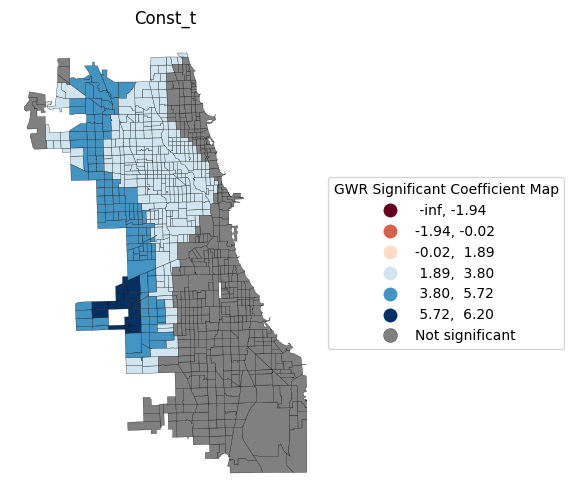

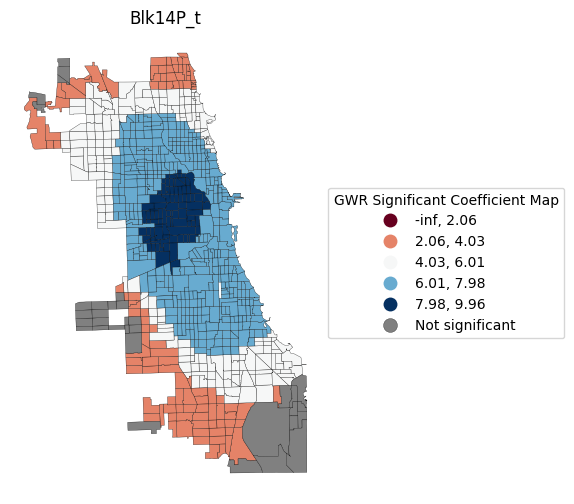

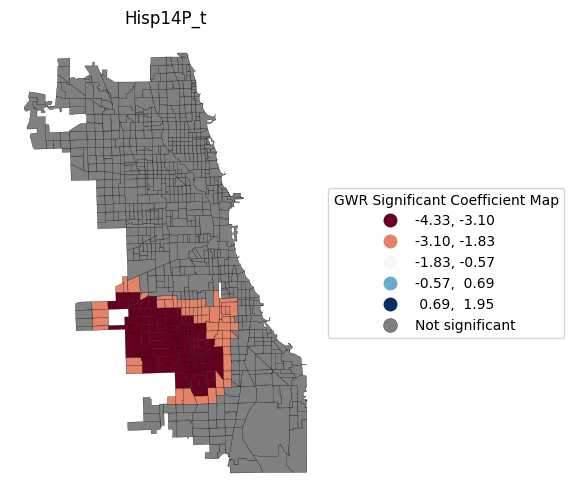

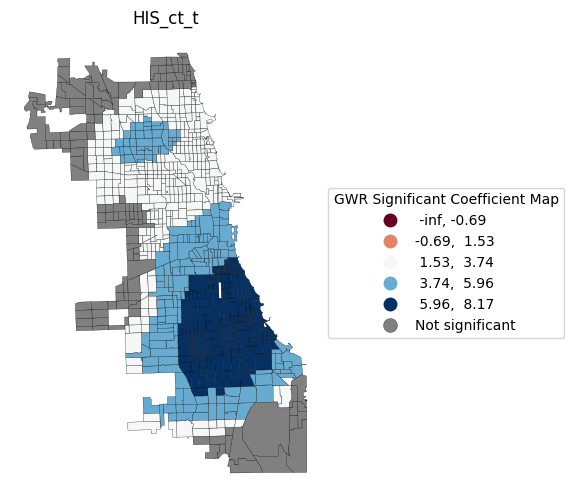

In [29]:
filter_t = gwr1.filter_tvals()
coefs2 = pd.DataFrame(filter_t,columns=['Const_t','Blk14P_t','Hisp14P_t','HIS_ct_t'])
print(np.round(coefs2.describe(),3))
coefs2['ID'] = range(1,n+1)
newdfs2 = dfs.merge(coefs2,on='ID')
vars = ['Const_t','Blk14P_t','Hisp14P_t','HIS_ct_t']
for var in vars:
    gwr_map(newdfs2,var,maptype='sig')

The results are strikingly different from before and give a more realistic picture of the coefficient variation, restricted to only those coefficients deemed to be significant. In other words, the other variation is noise that should be ignored. Note that the removal of the non-significant coefficients changes the descriptive statistics for the estimated coefficients and now provides a very different perspective compared to the global coefficients.

For example, for `HIS_ct`, the evidence of negative coefficients was removed since they turned out not to be significant. The map for `Hisp14P` highlights how the visualization of the point estimates can be misleading, since most of the coefficients turned out to not be significant.

### Local Fit

We can follow the same approach for the local measure of fit, the "R2" attribute of the result object. We list some descriptive statistics and plot the map using `'fit'` as the `maptype` for `gwr_map`.

In [15]:
print(np.round(newdfs1["R2"].describe(),3))
gwr_map(newdfs1,"R2",maptype='fit')

NameError: name 'newdfs1' is not defined

The map and descriptive statistics show a wide range of results, with even negative values for the local R2. The best values are obtained for the dark blue tracts, ranging from 0.64 to 0.75 (the upper bound of 0.90 in the map classification is generated by the break points in the box map). However, the mean value is 0.56, well below the fit of the global model.

### Sensitivity Analysis - Adaptive Bandwidth

As a comparison, we carry out the same procedure for an adaptive bandwidth model with
its associated optimal bandwidth, `bw=bwaaicc`. We now chain the construction of the GWR model
object with the `fit` method.

In [34]:
gwr2 = GWR(coords,y,x,bw=bwaaicc,kernel='bisquare').fit()
gwr2.summary()

Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2897332674.871
Log-likelihood:                                                   -7099.872
AIC:                                                              14207.744
AICc:                                                             14209.820
BIC:                                                           2897327422.985
R2:                                                                   0.633
Adj. R2:                                                              0.632

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

The mean of the GWR coefficient estimates does not differ much from the results for a fixed bandwidth, but the
range is smaller. Now, the distribution of the X1 (Blk14P) coefficient no longer crosses zero.

We visualize the results, but only for the significant coefficients. We follow the same procedure as above, using `maptype = 'sig'` for `gwr_map`.

In [16]:
filter_t2 = gwr2.filter_tvals()
coefs3 = pd.DataFrame(filter_t2,columns=['Const_t','Blk14P_t','Hisp14P_t','HIS_ct_t'])
print(np.round(coefs3.describe(),3))
coefs3['R2'] = gwr2.localR2
n = coefs3.shape[0]
coefs3['ID'] = range(1,n+1)
newdfs3 = dfs.merge(coefs3,on='ID')
vars = ["Const_t","Blk14P_t","Hisp14P_t","HIS_ct_t"]
for var in vars:
    gwr_map(newdfs3,var,maptype='sig')

NameError: name 'gwr2' is not defined

The results are strikingly different from the previous ones, which warrants further investigation. However, a detailed examination is beyond our current scope.

### Sensitivity Analysis - Kernel Function

We further consider the sensitivity of the results to the use of a different kernel function. We set `kernel = 'gaussian'` and use the `AICc` optimal bandwidth. This yields a fixed bandwidth of 50. First, we provide the usual summary, followed by the visualization of the significant coefficients.

In [36]:
bwgaicc = Sel_BW(coords,y,x,kernel='gaussian').search(criterion="AICc")
print("AICc bandwidth",bwgaicc)
gwr4 = GWR(coords,y,x,bw=bwgaicc,kernel='gaussian').fit()
gwr4.summary()

AICc bandwidth 50.0
Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2897332674.871
Log-likelihood:                                                   -7099.872
AIC:                                                              14207.744
AICc:                                                             14209.820
BIC:                                                           2897327422.985
R2:                                                                   0.633
Adj. R2:                                                              0.632

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ----

       Const_t  Blk14P_t  Hisp14P_t  HIS_ct_t       R2       ID
count  791.000   791.000    791.000   791.000  791.000  791.000
mean     1.509     4.851     -0.525     2.418    0.544  396.000
std      1.955     1.433      1.205     2.563    0.109  228.486
min      0.000     0.000     -4.004     0.000    0.310    1.000
25%      0.000     4.203      0.000     0.000    0.460  198.500
50%      0.000     5.007      0.000     2.674    0.528  396.000
75%      3.298     5.693      0.000     5.087    0.629  593.500
max      6.247     8.462      0.000     6.687    0.772  791.000


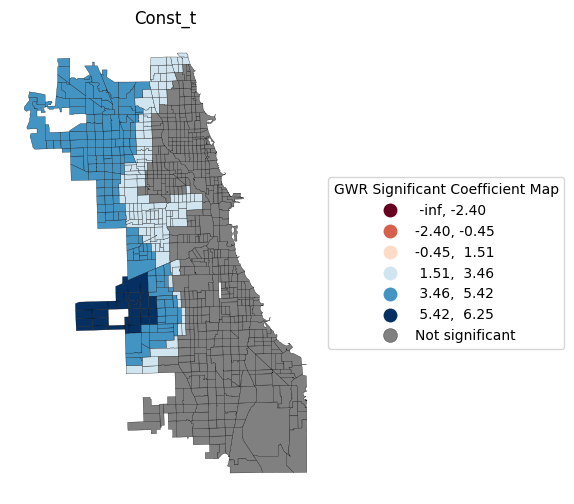

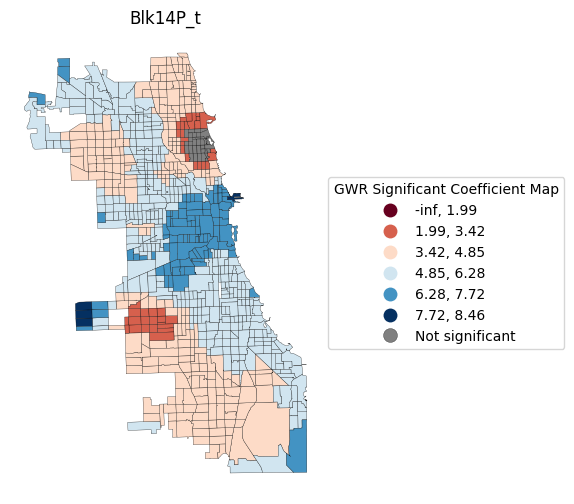

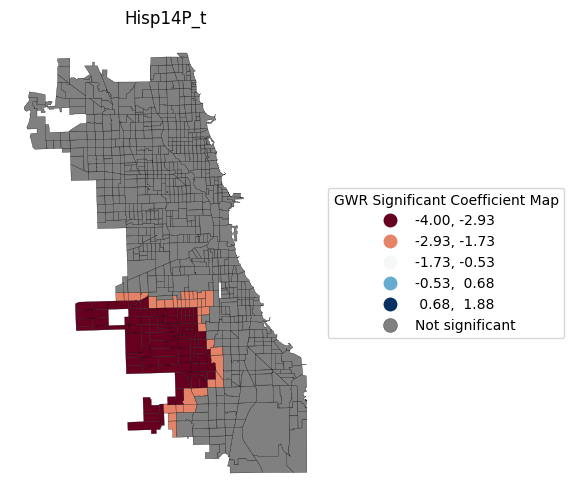

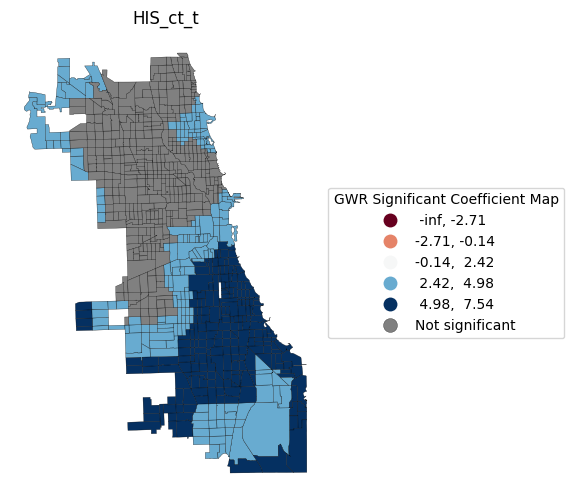

In [37]:
vars = ['Const_t','Blk14P_t','Hisp14P_t','HIS_ct_t']
filter_t3 = gwr4.filter_tvals()
coefs4 = pd.DataFrame(filter_t3,columns=vars)
coefs4['R2'] = gwr4.localR2
n = coefs4.shape[0]
coefs4['ID'] = range(1,n+1)
print(np.round(coefs4.describe(),3))
newdfs4 = dfs.merge(coefs4,on='ID')
for var in vars:
    gwr_map(newdfs4,var,maptype='sig')

## MGWR

Multiscale GWR is a generalization of the idea behind GWR in the sense of allowing a different bandwidth for each explanatory variable. In other words, the bandwidth is *estimated* together with the individual-location coefficients. This is implemented through a backfitting estimation routine which can take quite a long time to converge. In our example, this is not a serious issue, but in other empirical applications it may require resorting to considerable computing resources.

MGWR proceeds in generally the same way as GWR, except that an initial bandwidth selector object is passed as an argument to the estimation routine. The output has essentially the same structure as a GWR result object.

In contrast to GWR, MGWR requires both dependent and explanatory variables to be standardized. This is readily accomplished by means of the `sklearn.preprocessing` `StandardScaler` method.

In [17]:
s_y = StandardScaler().fit_transform(y)
s_x = StandardScaler().fit_transform(x)

The `Sel_BW` operation operates in the same way as before, exept that now the option `multi=True` must be specified. A `search` yields a starting solution. Note that this may take a while (e.g., around a minute).

In [18]:
bw_selector = Sel_BW(coords,s_y,s_x,kernel='bisquare',multi=True)

In [19]:
bw_selector.search()

array([707., 789., 789., 142.])

In [20]:
bw_selector.bw
print(type(bw_selector.bw))
print(len(bw_selector.bw))

<class 'tuple'>
7


The `bw_selector.search()` operation generates a complext tuple of starting values in the `bw_selector.bw` attribute. The selector object must be passed to the estimation routine. As for GWR, this creates an instance of a result object. Again, we can use the `summary` and `gwr_map` to visualize the results. This follows the same steps as before.

Note that because of the standardization, in this example the results for the constant are not significant.

In [21]:
mgwr1 = MGWR(coords,s_y,s_x,bw_selector).fit()

In [22]:
mgwr1.summary()

Model type                                                         Gaussian
Number of observations:                                                 791
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            290.274
Log-likelihood:                                                    -725.903
AIC:                                                               1459.806
AICc:                                                              1461.882
BIC:                                                              -4961.611
R2:                                                                   0.633
Adj. R2:                                                              0.632

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

       Blk14P_t  Hisp14P_t  HIS_ct_t       ID
count   791.000    791.000   791.000  791.000
mean      9.784     -2.901     3.686  396.000
std       0.113      0.020     2.643  228.486
min       9.529     -2.937     0.000    1.000
25%       9.692     -2.914     0.000  198.500
50%       9.807     -2.904     4.118  396.000
75%       9.888     -2.894     6.091  593.500
max       9.940     -2.829     8.214  791.000


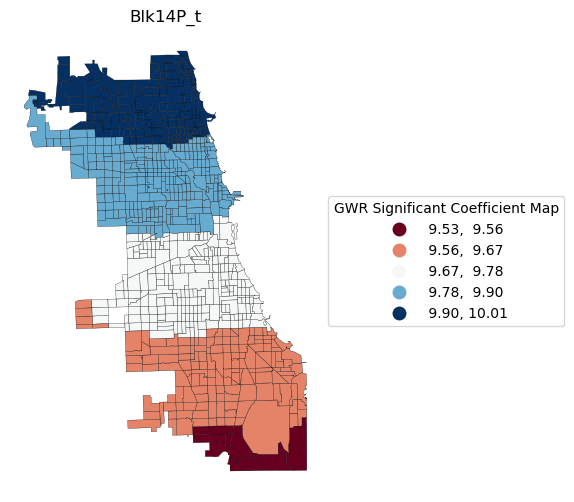

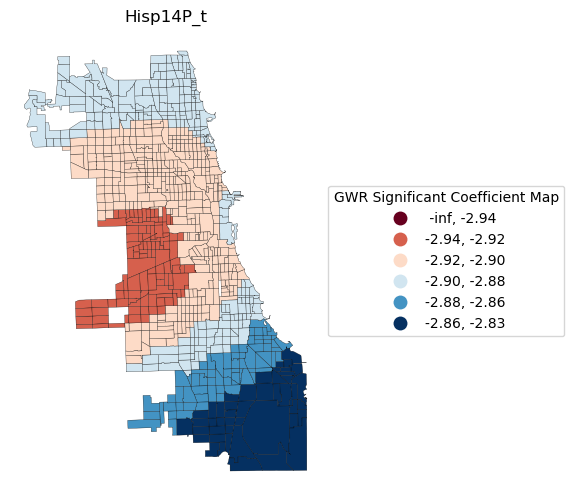

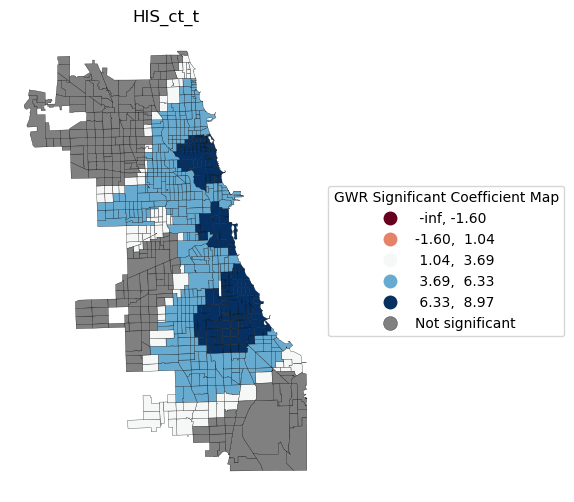

In [24]:
vars = ['Blk14P_t','Hisp14P_t','HIS_ct_t']
filter_mgwr = mgwr1.filter_tvals()
coefs5 = pd.DataFrame(filter_mgwr[:,1:],columns=vars)
n = coefs5.shape[0]
coefs5['ID'] = range(1,n+1)
print(np.round(coefs5.describe(),3))
newdfs5 = dfs.merge(coefs5,on='ID')
for var in vars:
    gwr_map(newdfs5,var,maptype='sig')

## Practice

GWR has many options to adjust bandwidth and kernel function, among others. Explore the sensitivity of your interpretation of spatial heterogeneity to these various settings. Also assess the effect of not choosing "optimal" bandwidths. 